# Tutorial 2: Escalamiento y transformaciones de imágenes

En este tutorial desarrollaremos implementaciones que nos permitirán cambiar las dimensiones de una imagen, su distribución geométrica y su distribución de intensidades. Además, estudiaremos a las imágenes como arreglos matriciales cuyos elementos corresponden a intensidades discretizadas, y comentaremos acerca del rol de las transformaciones de imágenes en el desarrollo de modelos.

## Escalamiento de imágenes

Cambiar las dimensiones de una imagen es un proceso crucial en el análisis y procesamiento de imágenes, ya sea porque se quiere editar su visualización, ajustarla a un tamaño requerido como entrada a un modelo, hacer un aumento de datos o emplear esta técnica con el fin de efectuar algún tipo de procesamiento del ruido.

Los procesos de reducir y aumentar las dimensiones de una imagen siguen fundamentos distintos. Al reducir las dimensiones, la nueva representación matricial de la imagen tiene menos elementos de los que había originalmente, por lo que se debe hacer una selección de algunas intensidades representativas de la imagen original. Esto conlleva una pérdida de información. Por otro lado, al aumentar las dimensiones, la nueva representación matricial tendrá más elementos de los que había originalmente, por lo que a estos se les deberá asignar intensidades basadas en el contexto de la imagen original. Esta adición de información que no corresponde precisamente a aquello representado en una primera instancia puede introducir artefactos en la visualización.

### Reducción de dimensiones

Una de las formas de reducir las dimensiones de una imagen es *submuestrear* intensidades distribuidas de forma homogénea. En otras palabras, esto corresponde a que la nueva representación matricial esté compuesta de elementos de la imagen original separados por un determinado número de filas y columnas. 

>**Ejercicio**: Cree una función que genere un submuestreo de una imagen. Entra por parametro la imagen y una tupla de dimensiones. Recuerde usar round()

In [ ]:
import numpy as np

def resize_subsample(image, dim):
    
    # Se definen las variables n, m, a y b según se describieron los parámetros de la función
    (n, m) = image.shape
    a, b = dim
    
    # Se inicializa la imagen escalada como una matriz de ceros con las dimensiones ingresadas como parámetro
    resized_image = np.zeros(dim)
    
    # Se define la distancia entre píxeles que se va a tomar vertical y horizontalmente (factor de escala)
    step_n = n / a
    step_m = m / b
    
    # Se asignan las intensidades de la imagen escalada a partir de submuestrear píxeles en de la imagen
    # original con una separación de aproximadamente step_n píxeles verticales y y step_m píxeles horizontales
    for i in range(a):
        for j in range(b):
            resized_image[i,j] = image[round(step_n * i), round(step_m * j)]
    return resized_image

In [ ]:
from skimage.io import imread

original_image = imread('rose.png', as_gray = True)
resize_image= resize_subsample(original_image,(400,400))
assert (resize_image.shape==(400,400))
assert (np.sum(resize_image)==7481907.0)

### Aumento de dimensiones

Al aumentar las dimensiones de una imagen, para determinar las intensidades asociadas a los elementos que no provienen de la imagen original se suele usar la *interpolación*, la cual es un proceso que consiste en asignar una intensidad resultante de un promedio ponderado de las intensidades originales locales. Una de las interpolaciones más simples es la interpolación bilineal, la cual corresponde a un promedio ponderado en el que se tienen en cuenta las intensidades de los 4 pixeles originales más cercanos y sus pesos asociados aumentan entre más cerca se está a dichos píxeles. A continuación, se presenta una representación gráfica de un ejemplo de interpolación bilineal:

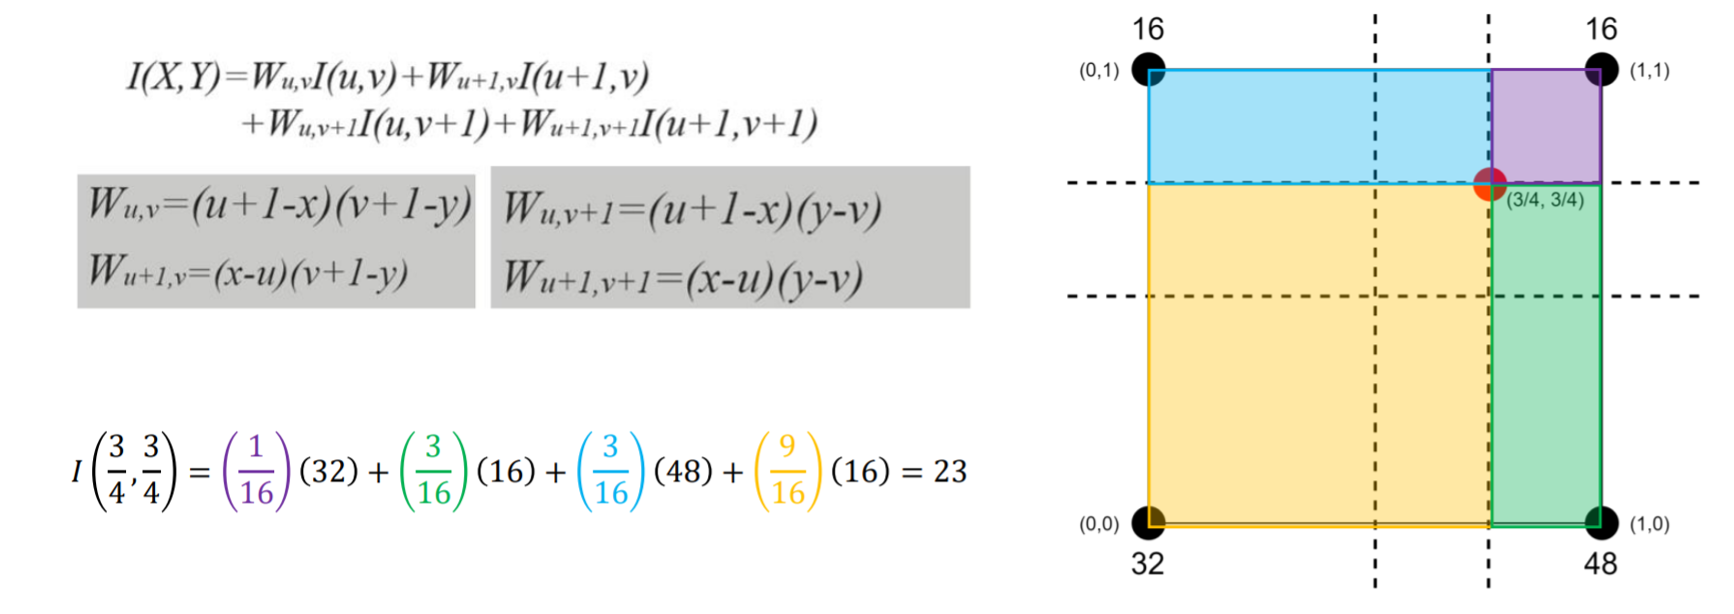

En este caso $I(i, j)$ e $W(i, j)$ corresponden a la intensidad y el peso asociado al píxel en la coordenada $(i, j)$ en el promedio ponderado de la interpolación bilineal. Gráficamente podemos identificar que los pesos son equivalentes al área de los 4 rectángulos que se forman al partir la región de interpolación empleando los 4 píxeles originales y la coordenada a interpolar como vértices. A continuación, se presentará la implementación de una función que emplea la interpolación bilineal para aumentar las dimensiones de una imagen de forma arbitraria a partir de unas nuevas dimensiones ingresadas como parámetro:

In [ ]:
import math

# Se define la función:

# El parámetro image corresponde a una imagen de un canal (escala de grises) representada
# por una matriz de dimensiones n x m (filas x columnas)

# El parámetro dim correponde a las nuevas dimensiones deseadas, una tupla (nueva cantidad de filas y nueva cantidad de columnas)

def resize_interpolation(image, dim):
    
    # Se definen las variables n, m, a y b según se describieron los parámetros de la función
    (n, m) = image.shape
    a,b = dim

    # Se inicializa la imagen escalada como una matriz de ceros con las dimensiones ingresadas como parámetro
    resized_image = np.zeros(dim)
    
    # Se calcula el factor de escala.
    step_n = n / a
    step_m = m / b
    
    for i in range(a):
        for j in range(b):
            
            # Mapeamos las coordenadas de la imagen escalada (i, j) a coordenadas en la escala de la imagen original (x, y)
            x, y = i * step_n, j * step_m
            
            # Encontramos las coordenadas de los 4 pixeles que corresponde a los vertices de la interpolación
            x_floor = math.floor(x)
            x_ceil = min(n - 1, math.ceil(x))
            y_floor = math.floor(y)
            y_ceil = min(m - 1, math.ceil(y))
            
            # Caso en el que el pixel a considerar es uno de los vértices
            if (x_floor == x_ceil) and (y_floor == y_ceil):
                resized_image[i,j] = image[int(x), int(y)]
            
            # Caso en el que el pixel a considerar se encuentra en una arista vertical
            elif x_floor == x_ceil:
                I1 = image[int(x), y_floor]
                I2 = image[int(x), y_ceil]
                resized_image[i,j] = (y - y_floor) * I1 + (y_ceil - y) * I2
            
            # Caso en el que el pixel a considerar se encuentra en una arista horizontal
            elif y_floor == y_ceil:
                I1 = image[x_floor, int(y)]
                I2 = image[x_ceil, int(y)]
                resized_image[i,j] = (x - x_floor) * I1 + (x_ceil - x) * I2
            
            # Caso general de interpolación bilineal
            else:
            
                # Obtenemos la intensidad de los vertices
                I1 = image[x_floor, y_floor]
                I2 = image[x_ceil, y_floor]
                I3 = image[x_floor, y_ceil]
                I4 = image[x_ceil, y_ceil]

                # Obtenemos los pesos de cada vértice a partir de las coordenadas
                W1 = (x - x_floor) * (y - y_floor)
                W2 = (x_ceil - x) * (y - y_floor)
                W3 = (x - x_floor) * (y_ceil - y)
                W4 = (x_ceil - x) * (y_ceil - y)

                # Aplicamos el promedio ponderado de la interpolación bilineal para asignar la intensidad de la imagen escalada
                resized_image[i,j] = W1 * I1 + W2 * I2 + W3 * I3 + W4 * I4
    
    # Se retorna la imagen escalada
    return resized_image

A continuación, se presentan los resultados de aumentar y reducir las dimensiones de una imagen a blanco y negro empleando las funciones previamente implementadas. Debido al tamaño de la imagen original y la implementación propuesta de la interpolación bilineal el código puede demorarse un poco en correr.

In [ ]:
from skimage.io import imread
import matplotlib.pyplot as plt

original_image = imread('rose.png', as_gray = True)

plt.figure(figsize=(10,8))

plt.subplot(131)
plt.title('Imagen Original\n' + str(original_image.shape))
plt.imshow(original_image, cmap = 'gray')

plt.subplot(132)
plt.title('Dimensiones reducidas\n(600, 400)')
plt.imshow(resize_subsample(original_image, (600, 400)), cmap = 'gray')

plt.subplot(133)
plt.title('Dimensiones aumentadas\n(1200, 1600)')
plt.imshow(resize_interpolation(original_image, (1200, 1600)), cmap = 'gray')

plt.tight_layout()

## **Ejercicio 1**: 
Piense cómo debe modificar estas funciones para que pueda cambiar las dimensiones de imágenes a color. Implemente una función que sirva tanto para aumentar como para reducir dimensiones en imágenes a color. 

> - Nota: Solo debe modificar un pequeño aspecto en el codigo proporcionado

In [ ]:
def resize_interpolation_RGB(image, dim):
    # YOUR CODE HERE
    raise NotImplementedError()
    # Se retorna la imagen escalada
    return resized_image

Observemos como funciona esta implementación.

In [ ]:
from skimage.io import imread
import matplotlib.pyplot as plt

original_image = imread('Perro.jpg')

plt.figure(figsize=(10,8))

plt.subplot(131)
plt.title('Imagen Original\n' + str(original_image.shape))
plt.imshow(original_image, cmap = 'gray')

plt.subplot(132)
plt.title('Dimensiones reducidas\n(600, 400)')
plt.imshow(resize_interpolation_RGB(original_image, (600, 400)), cmap = 'gray')

plt.subplot(133)
plt.title('Dimensiones aumentadas\n(1200, 1600)')
plt.imshow(resize_interpolation_RGB(original_image, (1200, 1600)), cmap = 'gray')

plt.tight_layout()

In [ ]:
original_image = imread('Perro.jpg')
resize_image= resize_interpolation_RGB(original_image, (600, 400))
assert (resize_image.shape==(600, 400,3)), f'Su imagen no tiene las nuevas dimensiones 600x400x3 sino {resize_image.shape}'
assert (np.sum(resize_image)==94826578), 'la imagen con la nueva dimensión es erronea'

## Transformaciones geométricas

Las *transformaciones geométricas* son funciones que mapean cada píxel (cuyas coordenadas podemos denotar como $(x, y)$) a una nueva posición $(x', y')$. Un subconjunto se estas transformaciones son las *transformaciones afines*, en las cuales las nuevas coordenadas se pueden expresar como una combinación lineal de las coordenadas originales:

\begin{equation}
x' = ax + by + m
\end{equation}
\begin{equation}
y' = cx + dy + n
\end{equation}

Estas transformaciones afines se pueden realizar aplicando un producto matricial entre una matriz de transformación y un vector asociado a las coordenadas de cada píxel, tal como se ha explicado en el curso. A continuación, se presentará una implementación de la transformación de traslación mediante este método:

In [ ]:
# Se define la función:

# El parámetro image corresponde a una imagen de un canal (escala de grises) representada
# por una matriz de dimensiones n x m (filas x columnas)

# El parámetro t correponde a una tupla de dos elementos enteros cuyo primer y segundo elemento corresponden
# a la cantidad de píxeles a trasladarse en dirección horizontal y vertical respectivamente

def translation(image, t):
    
    # Se define la traslación en x y y según la descripción de los parámetros y se crea una matriz de transformación
    tx, ty = t
    T = np.array([[1, 0, tx],
                  [0, 1, ty],
                  [0, 0, 1]])
    
    # Se inicializa la imagen trasladada como un arreglo de ceros de dimensiones iguales a la imagen original
    translated_image = np.zeros(image.shape)
    
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            
            # Para cada píxel de la imagen original se aplica la multiplicación matricial asociada a la
            # transformación para obtener las nuevas coordenadas
            X = np.array([x, y, 1]).T
            X_prime = np.matmul(T, X)
            x_prime, y_prime, _ = X_prime
            
            # Las intensidades asociadas a las coordenadas que se encuentran dentro de los límites dados
            # por las dimensiones originales son almacenadas en el arreglo a retornar
            if 0 <= x_prime < image.shape[0] and 0 <= y_prime < image.shape[1]:
                translated_image[x_prime, y_prime] = image[x, y]
    
    # Se retorna la imagen trasladada
    return translated_image

A continuación, se presenta una visualización de una imagen de una tortuga y las imágenes resultantes de traslaciones positivas y negativas sobre la original:

In [ ]:
original_image = imread('turtle.jpg', as_gray = True)

plt.figure(figsize=(10,8))

plt.subplot(131)
plt.title('Imagen Original')
plt.imshow(original_image, cmap = 'gray')
plt.axis('off')

plt.subplot(132)
plt.title('Imagen trasladada\n(50, 80)')
plt.imshow(translation(original_image, (50, 60)), cmap = 'gray')
plt.axis('off')

plt.subplot(133)
plt.title('Imagen trasladada\n(-80, -100)')
plt.imshow(translation(original_image, (-80, -100)), cmap = 'gray')
plt.axis('off')

plt.tight_layout()

A continuación, tiene una función que genera una transformación unica indicada (no secuencial) Note que lo importante de la implementación es la matriz. Tomese el trabajo de entender la función que se le preporciona.

In [ ]:
def transformacion(image, t,s,angulo):
    
    # Se define la traslación en x y y según la descripción de los parámetros y se crea una matriz de transformación
    if t !=0:
        tx, ty = t
        T = np.array([[1, 0, tx],
                  [0, 1, ty],
                  [0, 0, 1]])
    elif s !=0:
        sh, sv = s
        T = np.array([[1, sh, 0],
                  [sv, 1, 0],
                  [0, 0, 1]])
    elif angulo!=0:
        T = np.array([[np.cos(angulo), -np.sin(angulo), 0],
                  [np.sin(angulo), np.cos(angulo), 0],
                  [0, 0, 1]])
    # Se inicializa la imagen trasladada como un arreglo de ceros de dimensiones iguales a la imagen original
    translated_image = np.zeros(image.shape)
    
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            
            # Para cada píxel de la imagen original se aplica la multiplicación matricial asociada a la
            # transformación para obtener las nuevas coordenadas
            X = np.array([x, y, 1]).T
            X_prime = np.matmul(T, X)
            x_prime, y_prime, _ = X_prime
            x_prime=int(x_prime)
            y_prime=int(y_prime)
            # Las intensidades asociadas a las coordenadas que se encuentran dentro de los límites dados
            # por las dimensiones originales son almacenadas en el arreglo a retornar
            if 0 <= x_prime < image.shape[0] and 0 <= y_prime < image.shape[1]:
                translated_image[x_prime, y_prime] = image[x, y]
    
    # Se retorna la imagen trasladada
    return translated_image

A continuación, se presenta una visualización de una imagen de una tortuga y las imágenes resultantes de traslacion, share y rotación.

In [ ]:
original_image = imread('turtle.jpg', as_gray = True)

plt.figure(figsize=(10,8))

plt.subplot(131)
plt.title('Imagen Original')
plt.imshow(original_image, cmap = 'gray')
plt.axis('off')

plt.subplot(132)
plt.title('Imagen share')
plt.imshow(transformacion(original_image,0, (0.5,0.5),0), cmap = 'gray')
plt.axis('off')

plt.subplot(133)
plt.title('Imagen rotación 45 grados')
plt.imshow(transformacion(original_image,0,0,np.pi/4), cmap = 'gray')
plt.axis('off')

plt.tight_layout()

## Ejercicio 2:
Ahora, modifique la función anterior para realizar transformaciones de forma sequencial. El parámetro adicional "sequence" será una tupla con strings con las transformaciones en secuencia. Use la información de las demás variables para realizar las transformaciones.

In [ ]:
def transformacion_sequence(image, sequence,t,s,angulo):
    'squence (tuple): Una tupla de strings, los strings pueden ser "t","a" o "s" siendo translación, angulo y share respectivamente'
    # YOUR CODE HERE
    raise NotImplementedError()
    return translated_image

In [ ]:
original_image = imread('turtle.jpg', as_gray = True)

plt.figure(figsize=(20,8))

plt.subplot(151)
plt.title('Imagen Original')
plt.imshow(original_image, cmap = 'gray')
plt.axis('off')

plt.subplot(152)
plt.title('Imagen share y translación')
transform_s_t=transformacion_sequence(original_image,('s','t'),(20,10), (0.2,0.2),0)
plt.imshow(transform_s_t, cmap = 'gray')
plt.axis('off')

plt.subplot(153)
plt.title('Imagen rotación y translación')
transform_a_t=transformacion_sequence(original_image,('a','t'),(20,10),0,np.pi/8)
plt.imshow(transform_a_t, cmap = 'gray')
plt.axis('off')

plt.subplot(154)
plt.title('Imagen rotación y share')
transform_a_s=transformacion_sequence(original_image,('a','s'),0,(0.2,0.2),np.pi/8)
plt.imshow(transform_a_s, cmap = 'gray')
plt.axis('off')

plt.subplot(155)
plt.title('Imagen share y rotación')
transform_s_a=transformacion_sequence(original_image,('s','a'),0,(0.2,0.2),np.pi/8)
plt.imshow(transform_s_a, cmap = 'gray')
plt.axis('off')

plt.tight_layout()

In [ ]:
assert np.isclose(np.sum(transform_s_t-transformacion(transformacion(original_image,0,(0.2,0.2),0),(20,10),0,0)),0), 'Su secuencia de transformaciones por función no es igual a la secuencia de transformaciones de forma idependiente'
assert np.sum(transform_a_t-transformacion(transformacion(original_image,0,0,np.pi/8),(20,10),0,0))!=0, 'Usted uso la función dada de forma iterativa'
assert np.sum(transform_a_s-transform_s_a)!=0, 'Su secuencia de rotacion-share deberia ser diferente a share-rotacion'
assert np.isclose(np.sum(transform_s_a==0),47274), 'Su implementación es erronea'

## Transformaciones de intensidad

Las *transformaciones de intensidad* consisten en aplicar una función a las intensidades de los píxeles de una imagen, de tal forma que estas varíen dentro del rango delimitado por su representación discreta propia. Si bien estas transformaciones pueden ser usadas como una forma de aumento de datos, teniendo en cuenta que permiten variar propiedades de la imagen como su contraste y realzar algunas intensidades de interés también se usa para mejorar la calidad de la imagen para una aplicación en específico. En esta sección desarrollaremos una función que nos permita realizar transformaciones exponenciales y de calibración de contraste. Las transformaciones de intensidad se pueden visualizar mediante una función que tiene como variable independiente las intensidades originales y como variable dependiente las intensidades de salida en el rango definido por la representación discreta de la imagen. Particularmente, la visualización de las transformaciones exponenciales y de calibración de contraste corresponden a las siguientes gráficas:

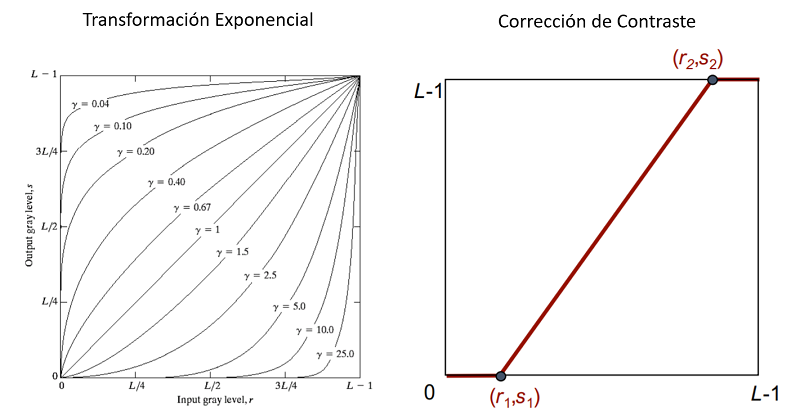

Para formular correctamente las funciones asociadas a estas transformaciones debemos comprender la representación de la imagen a trabajar. En esta ocasión trabajaremos con la imagen de un lago:

In [ ]:
original_image = imread('lake.jpg', as_gray = True)
print('La intensidad mínima de la imagen es: ' + str(np.min(original_image)))
print('La intensidad máxima de la imagen es: ' + str(np.max(original_image)))

Al cargar las imágenes mediante la función `skimage.io.imread` con el parámetro `as_gray = True`, estas son representadas por arreglos de dos dimensiones para los cuales cada intensidad se encuentra normalizada entre 0 y 1. Podemos pasar a una representación de 8 bits (256 niveles de intensidad discretos asociados a números enteros) multiplicando estos arreglos por 255 y pasando de representación de punto flotante a entero:

In [ ]:
original_image = (original_image * 255).astype(int)
print("Las intensidades del nuevo arreglo en representación de 8 bits son:")
np.unique(original_image)

## Problema 3:

La transformación exponencial está dada por la siguiente función:
\begin{equation}
s = c r^{\gamma}
\end{equation}
donde $r$ es la intensidad original, $s$ es la intensidad resultante y $c$ y $\gamma$ son constantes positivas. La constante $c$ se elige de tal forma que la intensidad más alta de la representación permanezca invariante para un $\gamma$ ingresado como parámetro:
\begin{equation}
r_{max} = r_{max}^{\gamma}
\end{equation}

Cree la función que retorne la imagen transformada.

In [ ]:
def exponential_transform(image, gamma):
    # YOUR CODE HERE
    raise NotImplementedError()
    return transformed_image

In [ ]:
assert np.max(exponential_transform(original_image,2))==np.max(original_image)**2, 'La transformación es erronea, el maximo de la imagen resultante debería ser el maximo de la imagen original elevado a gamma'
assert np.min(exponential_transform(original_image,2))==np.min(original_image)**2, 'La transformación es erronea, el minimo de la imagen resultante debería ser el minimo de la imagen original elevado a gamma'

In [ ]:
print(f'El maximo de la imagen resultado es: {np.max(exponential_transform(original_image,2))}, ¿Esto es lo que deseamos?, la imagen debe estar entre 0 y 255')

Cambie su función para que retorne las imagenes en mismo rango de entrada.

In [ ]:
def exponential_transform(image, gamma):
    # YOUR CODE HERE
    raise NotImplementedError()
    return transformed_image

In [ ]:
assert np.max(exponential_transform(original_image,2))<255, 'El maximo del resultado no debe ser mayor a 255'

El siguiente fragmento de código realiza una visualización de nuestra imagen original junto con transformaciones con $\gamma < 1$ y $\gamma > 1$:

In [ ]:
plt.figure(figsize=(15,8))

plt.subplot(131)
plt.title('Imagen Original')
plt.imshow(original_image, cmap = 'gray')
plt.axis('Off')

plt.subplot(132)
plt.title(r'$\gamma = 0.5$')
plt.imshow(exponential_transform(original_image, 0.5), cmap = 'gray')
plt.axis('Off')

plt.subplot(133)
plt.title(r'$\gamma = 2.0$')
plt.imshow(exponential_transform(original_image, 2.0), cmap = 'gray')
plt.axis('Off')

plt.tight_layout()

Cuál es la diferencia entre aplicar una transformación exponencial con $\gamma < 1$ y $\gamma > 1$?

La transformación de corrección de contraste es un caso particular de una transformación lineal definida a trozos. En ella, las intensidades menores a $r_1$ se umbralizan a la menor intensidad de la representación ($s_1$), y los valores mayores a $r_2$ se umbralizan a la mayor intensidad de la representación ($s_2$). 

In [ ]:
def contrast_correction(image, r1, r2):
    
    transformed_image = np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Cuando la intensidad es menor al primer umbral, se mapea a la menor intensidad posible
            if image[i, j] < r1:
                transformed_image[i, j] = 0
            # Cuando la intensidad se encuentra entre ambos umbrales, se mapea según una función lineal
            elif r1 < image[i, j] < r2:
                transformed_image[i, j] = 255 * (image[i, j] - r1) / (r2 - r1)
            # Cuando la intensidad es mayor al segundo umbral, se mapea a la mayor intensidad posible
            else:
                transformed_image[i, j] = 255
    
    return transformed_image

In [ ]:
plt.figure(figsize=(15,8))

original_image = imread('lake.jpg', as_gray = True)
original_image = (original_image * 255).astype(int)
plt.subplot(131)
plt.title('Imagen Original')
plt.imshow(original_image, cmap = 'gray')
plt.axis('Off')

plt.subplot(132)
plt.title('Correción umbral 20-100')
plt.imshow(contrast_correction(original_image, 20,100), cmap = 'gray')
plt.axis('Off')

plt.subplot(133)
plt.title('Correción umbral 100-200')
plt.imshow(contrast_correction(original_image, 100,200), cmap = 'gray')
plt.axis('Off')

plt.tight_layout()